# Prediction (Supervised learning)

### Dataset and Problem Setup

This notebook focuses on the supervised learning part of the project.  
The goal is to predict whether an e-commerce session results in a purchase, using behavioural features from the Online Shoppers Purchasing Intention dataset. The target variable is `Revenue`, which indicates whether a purchase was completed during a session.

In [1]:
import pandas as pd
df = pd.read_csv("online_shoppers_intention.csv")

df.head()
df.info()
df["Revenue"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

In [2]:
X = df.drop("Revenue", axis=1)
y = df["Revenue"]

### Train–Test Split

The dataset is split into training and test sets before any preprocessing or model training.  
Stratified sampling is used to preserve the imbalance between purchasing and non-purchasing sessions in both sets and to ensure a fair evaluation.


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Preprocessing

Numerical and categorical features are processed separately.  
Numerical features are standardised, while categorical features are encoded using one-hot encoding. The preprocessing steps are later integrated into the model pipelines to avoid data leakage.


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define categorical and numeric features explicitly
categorical_features = [
    "Month", "VisitorType", "Weekend",
    "Browser", "Region", "TrafficType", "OperatingSystems"
]

numeric_features = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

### Supervised Learning Models

Three supervised classification models are defined: Logistic Regression, Decision Tree, and Random Forest.  
Logistic Regression is used as an interpretable baseline model, Decision Trees capture non-linear decision rules, and Random Forest is included as a robust ensemble model suitable for tabular data.


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

dt_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=1
    ))
])

> Using class_weight=balanced and such the model is forced to treat one error on a "Buyer" as equally bad as multiple errors on "Non-Buyers." This effectively neutralizes the bias toward the majority class.

### Baseline Model Evaluation

The supervised models are evaluated using multiple metrics, including precision, recall, F1-score, ROC-AUC, and log-loss.  
Using several metrics is necessary due to class imbalance and to assess both classification performance and probability quality.
In addition to standard evaluation, Youden’s Index is used to analyse the effect of different classification thresholds. This analysis illustrates how threshold choice influences the trade-off between sensitivity and specificity.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, log_loss, roc_curve
import numpy as np

def evaluate (model, X_train, y_train, X_test, y_test, name="model"):
    # Ensure y is a plain 1D int array (0/1)
    y_train_int = np.array(y_train).astype(int).ravel()
    y_test_int = np.array(y_test).astype(int).ravel() 
    
    # Fit the model
    model.fit(X_train, y_train_int)

    # Get predicted probabilities
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Calculate Youden's Index (Optimal Threshold) on TRAIN data
    # We use TRAIN data to avoid data leakage
    fpr, tpr, thresholds = roc_curve(y_train_int, y_proba_train)
    youden_index = tpr - fpr
    # Get the threshold that maximizes Youden's Index
    best_threshold = thresholds[np.argmax(youden_index)]
    
    # Apply the optimal threshold to TEST data
    y_pred_optimized = (y_proba_test >= best_threshold).astype(int)

    print(f"\n=== {name} ===")
    print(classification_report(y_test_int, y_pred_optimized))
    print(f"Optimal Threshold: {best_threshold:.4f}")
    # ROC-AUC measures how well the model understands the difference between a Buyer and a Non-Buyer
    print("ROC-AUC:", roc_auc_score(y_test_int,y_proba_test))
    print("Log-loss:", log_loss(y_test_int, y_proba_test))

evaluate(logreg_pipeline, X_train, y_train, X_test, y_test, "Logistic Regression")
evaluate(dt_pipeline, X_train, y_train, X_test, y_test, "Decision Tree")
evaluate(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      2084
           1       0.43      0.79      0.56       382

    accuracy                           0.81      2466
   macro avg       0.69      0.80      0.72      2466
weighted avg       0.87      0.81      0.83      2466

Optimal Threshold: 0.4375
ROC-AUC: 0.8932442142074746
Log-loss: 0.45588421373136856

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2084
           1       0.52      0.53      0.52       382

    accuracy                           0.85      2466
   macro avg       0.72      0.72      0.72      2466
weighted avg       0.85      0.85      0.85      2466

Optimal Threshold: 1.0000
ROC-AUC: 0.7195322627649204
Log-loss: 5.364160905841848

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2

> Random Forest has the highest ROC-AUC (0.92) and Precision (0.79), but only a Recall of 0.40 meaning it is more conservative and does not accept as buyers unless it is very sure. While Logistic Regression found more buyers (Recall 0.79), it had too many false alarms (Precision 0.43). 

> We choose Random Forest because it is the most robust and accurate model, minimizing wasted resources on non-buyers, which aligns with our research question that focuses on the accuracy of predicting purchase intention. We will now tune it to compare and find the best version of the model

### Hyperparameter Tuning (Random Forest)

Hyperparameter tuning is performed for the Random Forest model to improve baseline performance while keeping the experimental setup controlled.  
A limited cross-validated search is used to keep computational cost proportional to the project scope. The tuned model is later used for final evaluation.


In [7]:
# Hyperparameter tuning for Random Forest (baseline)
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold

# Force y to a plain 1D int array (0/1) to avoid any dtype edge-cases
y_train_fixed = (
    y_train.values.ravel() if hasattr(y_train, "values") else np.array(y_train).ravel()
).astype(int)

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 20],
    "model__min_samples_leaf": [1, 5]
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train, y_train_fixed)

tuned_rf_pipeline = grid.best_estimator_

print("Best CV ROC-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best CV ROC-AUC: 0.9280743513199856
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 400}


### Evaluating the tuned Random Forest model

In [8]:
evaluate(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")
evaluate(tuned_rf_pipeline, X_train, y_train, X_test, y_test, "Tuned Random Forest")


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2084
           1       0.79      0.40      0.53       382

    accuracy                           0.89      2466
   macro avg       0.84      0.69      0.74      2466
weighted avg       0.88      0.89      0.88      2466

Optimal Threshold: 0.5500
ROC-AUC: 0.9187859884836851
Log-loss: 0.25754333726782075

=== Tuned Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2084
           1       0.53      0.84      0.65       382

    accuracy                           0.86      2466
   macro avg       0.75      0.85      0.78      2466
weighted avg       0.90      0.86      0.87      2466

Optimal Threshold: 0.3961
ROC-AUC: 0.9224432474801781
Log-loss: 0.2987712181596724


> While the tuned model has lower precision (0.53) and log-loss (0.2987) than the untuned, the recall jumped from 0.40 to 0.84 and the threshold got much lower. Now the model does not turn away as many difficult-to-spot buyers as it did before. The f1-score (from 0.53 to 0.65) also got better which means the model is mathematically better at balancing precision and recall. The ROC-AUC also saw a small increase of 0.0037.

> Comparing with Logistic Regression, the tuned model has a better recall, f1-score, precision, ROC-AUC and log-loss along with lower threshold. This means that it makes up for the low recall in the untuned while still being close to the untuned precision.

## Feature importance analysis of Tuned Random Forest

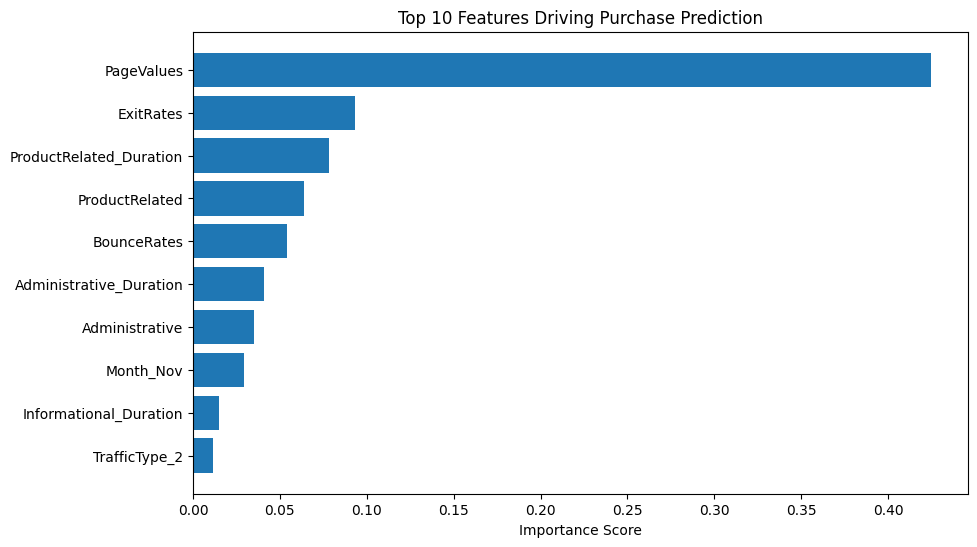

Total features: 75


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the model from the pipeline
rf_model = tuned_rf_pipeline.named_steps['model']
preprocessor = tuned_rf_pipeline.named_steps['preprocessor']

# Get feature names from the one-hot encoder
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

# Create a dataframe of importances
importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
plt.barh(importances['Feature'][:10], importances['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Features Driving Purchase Prediction")
plt.xlabel("Importance Score")
plt.show()

print('Total features:', len(all_feature_names))